# **Sistema de Clasificación de Cafés Basado en Perfiles Sensoriales**
Diseñar un sistema de clasificación basado en análisis de datos que permita categorizar cafés según su calidad sensorial a partir de atributos como aroma, sabor, acidez, cuerpo, balance y otros indicadores de cata.

## **Objetivos específicos**

* Construir un modelo de predicción de calidad (puntaje SCA) a partir de atributos físicos y sensoriales del café.

* Clasificar los cafés en niveles de calidad (estándar, premium, especialidad).


link dataSet: https://www.kaggle.com/datasets/volpatto/coffee-quality-database-from-cqi

link Presentacion: https://drive.google.com/file/d/148je-zs-0--Px19tnWBcOAhWIFGT2h48/view?usp=sharing

##**1.  Importacion de librerias**

In [ ]:
# Descarga de datasets (Kaggle)
import kagglehub
import os


# Manejo y análisis de datos
import pandas as pd
import numpy as np

# Visualizacion
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración estetica
sns.set(style="whitegrid", font_scale=1.0)

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer

# Metricas de evaluación
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    balanced_accuracy_score,
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score
)

# Balanceo de clases
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


##**2.Carga del dataset**
En esta sección se descarga el dataset **Coffee Quality Database (CQI)** desde Kaggle usando la librería `kagglehub`.
Posteriormente, se carga el archivo `arabica_data_cleaned.csv` en un DataFrame de pandas y se eliminan columnas innecesarias.

In [ ]:
#Descarga del dataset desde Kaggle
path = kagglehub.dataset_download("volpatto/coffee-quality-database-from-cqi")

# Mostrar ruta de descarga y archivos disponibles
print("Ruta del dataset:", path)
print("Archivos en la carpeta:", os.listdir(path))

# Cargar el archivo principal en un DataFrame
df = pd.read_csv(os.path.join(path, "arabica_data_cleaned.csv"))

# Eliminar columnas innecesarias
df = df.drop(columns=["Unnamed: 0", "ID"], errors="ignore")

# Vista rapida del dataset
df


Using Colab cache for faster access to the 'coffee-quality-database-from-cqi' dataset.
Ruta del dataset: /kaggle/input/coffee-quality-database-from-cqi
Archivos en la carpeta: ['merged_data_cleaned.csv', 'arabica_data_cleaned.csv', 'robusta_data_cleaned.csv']


,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.00,2200.00,2075.00
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.00,2200.00,2075.00
2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.00,1800.00,1700.00
3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,oromia,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.00,2200.00,2000.00
4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.00,2200.00,2075.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,Arabica,juan carlos garcia lopez,Mexico,el centenario,NaN,"la esperanza, municipio juchique de ferrer, ve...",1104328663,terra mia,900,juchique de ferrer,...,NaN,20,"September 17th, 2013",AMECAFE,59e396ad6e22a1c22b248f958e1da2bd8af85272,0eb4ee5b3f47b20b049548a2fd1e7d4a2b70d0a7,m,900.00,900.00,900.00
1307,Arabica,myriam kaplan-pasternak,Haiti,200 farms,NaN,coeb koperativ ekselsyo basen (350 members),NaN,haiti coffee,~350m,"department d'artibonite , haiti",...,Blue-Green,16,"May 24th, 2013",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,350.00,350.00,350.00
1308,Arabica,"exportadora atlantic, s.a.",Nicaragua,finca las marías,017-053-0211/ 017-053-0212,beneficio atlantic condega,017-053-0211/ 017-053-0212,exportadora atlantic s.a,1100,jalapa,...,Green,5,"June 6th, 2018",Instituto Hondureño del Café,b4660a57e9f8cc613ae5b8f02bfce8634c763ab4,7f521ca403540f81ec99daec7da19c2788393880,m,1100.00,1100.00,1100.00
1309,Arabica,juan luis alvarado romero,Guatemala,finca el limon,NaN,beneficio serben,11/853/165,unicafe,4650,nuevo oriente,...,Green,4,"May 24th, 2013",Asociacion Nacional Del Café,b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53,724f04ad10ed31dbb9d260f0dfd221ba48be8a95,ft,1417.32,1417.32,1417.32


##**3. Análisis Exploratorio de Datos (EDA)**

En esta sección se realiza un análisis exploratorio completo del dataset de **Coffee Quality (CQI)** con los siguientes pasos:

1. **Resumen inicial**  
   - `df.info()` → Estructura, tipos de datos y valores no nulos.  
   - `df.describe(include='all')` → Estadísticas descriptivas (numéricas y categóricas).  
   - `df.isnull().sum()` → Conteo de valores nulos.  

2. **Limpieza de datos**  
   - Eliminación de columnas constantes.  
   - Eliminación de duplicados.    

3. **Creacion de variable Categorica (quality_tier)**
   - Apartir de total_cup_points se definen 3 Categorias
   1. estandar: Cafes con menos de 80 puntos
   2. premium: Cafes entre 80 y 85 puntos
   3. especialidad: Cafes con mas de 85 puntos

4. **EDA univariado**  
   - Histogramas para variables numéricas.  
   - Gráficos de barras para variables categóricas.  

5. **Atributos sensoriales principales**  
   - Análisis de Aroma, Flavor, Aftertaste, Acidity, Body, Balance, Uniformity, Clean Cup, Sweetness y Overall por quality_tier.  

6. **Correlaciones**  
   - Matriz de correlación y mapa de calor entre variables numéricas.  
   - Identificación de atributos más relacionados con total_cup_points.

7. **Importancia de variables (RandomForest Regressor)**  
   - Modelo para determinar variables más relevantes en la predicción de total_cup_points.


###3.1. Resumen Incial

In [ ]:
#Informe general de Data Frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Species                1311 non-null   object 
 1   Owner                  1304 non-null   object 
 2   Country.of.Origin      1310 non-null   object 
 3   Farm.Name              955 non-null    object 
 4   Lot.Number             270 non-null    object 
 5   Mill                   1001 non-null   object 
 6   ICO.Number             1163 non-null   object 
 7   Company                1102 non-null   object 
 8   Altitude               1088 non-null   object 
 9   Region                 1254 non-null   object 
 10  Producer               1081 non-null   object 
 11  Number.of.Bags         1311 non-null   int64  
 12  Bag.Weight             1311 non-null   object 
 13  In.Country.Partner     1311 non-null   object 
 14  Harvest.Year           1264 non-null   object 
 15  Grad

In [ ]:
#Resumen  estadistadistico del data setr
num_cols_df = df.select_dtypes(include=[np.number])
display(num_cols_df.describe())

,Number.of.Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_low_meters,altitude_high_meters,altitude_mean_meters
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.00000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1310.000000,1311.000000,1084.000000,1084.000000,1084.000000
mean,153.887872,7.563806,7.518070,7.397696,7.533112,7.517727,7.517506,9.833394,9.83312,9.903272,7.497864,82.115927,0.088863,0.426392,0.177099,3.591915,1759.548954,1808.843803,1784.196379
std,129.733734,0.378666,0.399979,0.405119,0.381599,0.359213,0.406316,0.559343,0.77135,0.530832,0.474610,3.515761,0.047957,1.832415,0.840583,5.350371,8767.847252,8767.187498,8767.016913
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,14.500000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.00000,10.000000,7.250000,81.170000,0.090000,0.000000,0.000000,0.000000,1100.000000,1100.000000,1100.000000
50%,175.000000,7.580000,7.580000,7.420000,7.500000,7.500000,7.500000,10.000000,10.00000,10.000000,7.500000,82.500000,0.110000,0.000000,0.000000,2.000000,1310.640000,1350.000000,1310.640000
75%,275.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.00000,10.000000,7.750000,83.670000,0.120000,0.000000,0.000000,4.000000,1600.000000,1650.000000,1600.000000
max,1062.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.00000,10.000000,10.000000,90.580000,0.280000,31.000000,11.000000,55.000000,190164.000000,190164.000000,190164.000000


In [ ]:
#valores nulos por columna
df.isnull().sum().sort_values(ascending=False)

,0
Lot.Number,1041
Farm.Name,356
Mill,310
Color,267
Producer,230
altitude_high_meters,227
altitude_low_meters,227
altitude_mean_meters,227
Altitude,223
Company,209


### 3.2. Limpieza de datos

In [ ]:
#Limpieza de datos
df = df.drop_duplicates()

# Eliminar columnas constantes
num_cols = df.select_dtypes(include=[np.number]).columns
const_cols = [c for c in num_cols if df[c].std() == 0]
df = df.drop(columns=const_cols)

print("Dataset despues de aplicarle limpieza de datos",df.shape)

Dataset despues de aplicarle limpieza de datos (1311, 43)


### 3.3. Creacion de variable Categorica (quality_tier)

In [ ]:
points_col = "Total.Cup.Points"
df['quality_tier'] = pd.cut(df[points_col],
                           bins=[-np.inf, 80, 85, np.inf],
                           labels=["estandar", "premium", "especialidad"])

print("\nDistribucion de Calidad de Cafes:")
print(df['quality_tier'].value_counts())



Distribucion de Calidad de Cafes:
quality_tier
premium         1026
estandar         189
especialidad      96
Name: count, dtype: int64


Como podemos oobservar la mayoria de los cafes se ubican en la caegoria premiun, seguidos por la especial

### 3.4. EDA Univariado

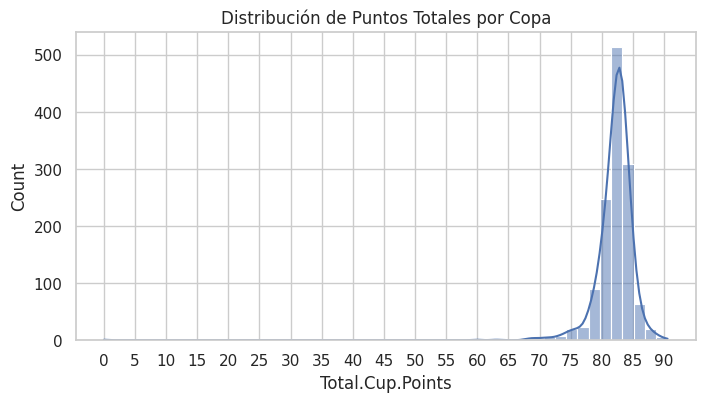

In [ ]:
#Histograma para variable numerica
plt.figure(figsize=(8,4))
sns.histplot(df[points_col], kde=True, bins=50)
plt.title("Distribución de Puntos Totales por Copa")
plt.xticks(np.arange(df[points_col].min(), df[points_col].max()+1, 5))
plt.show()

En el grafico podemos observar que la mayoria de cafes tienen puntuaciones de total puntos por copa entrre 80 y 85 lo que confirma el predominio de cafes de calidad Premium

/tmp/ipython-input-3123887309.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


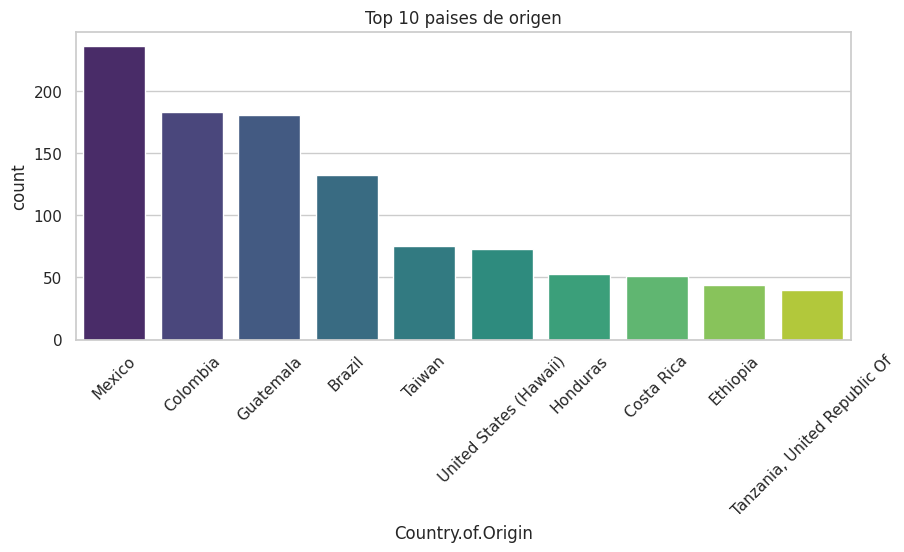

In [ ]:
#Grafico de barras para variable categorica (Pasi de Origen).

top_n = 10
col = "Country.of.Origin"

plt.figure(figsize=(10,4))
sns.countplot(
    data=df,
    x=col,
    order=df[col].value_counts().index[:top_n],
    palette="viridis"
)
plt.title(f"Top {top_n} paises de origen")
plt.xticks(rotation=45)
plt.show()


### 3.5. Atributos sensoriales principales

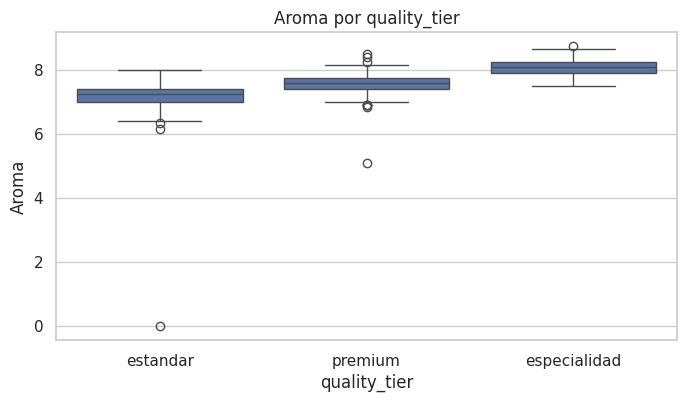

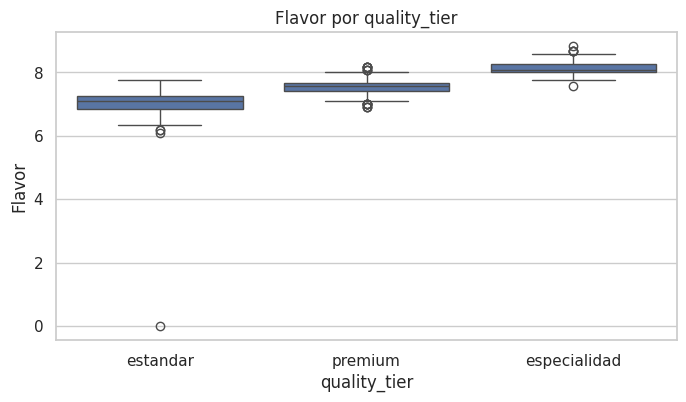

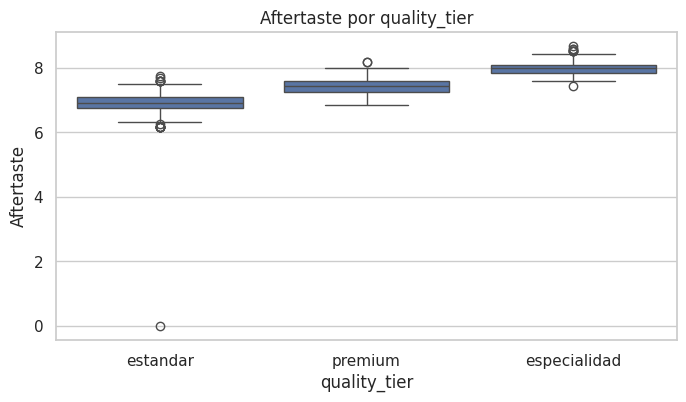

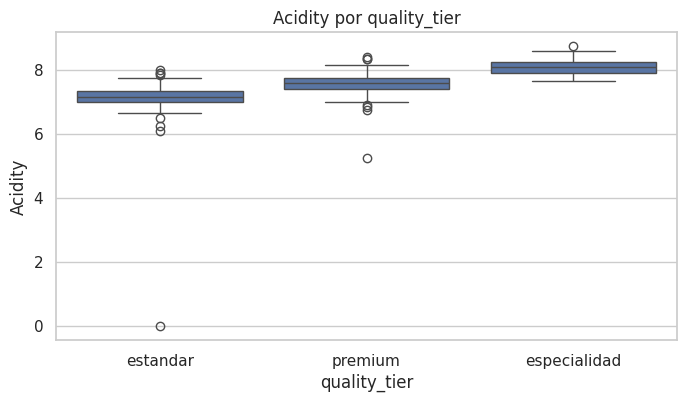

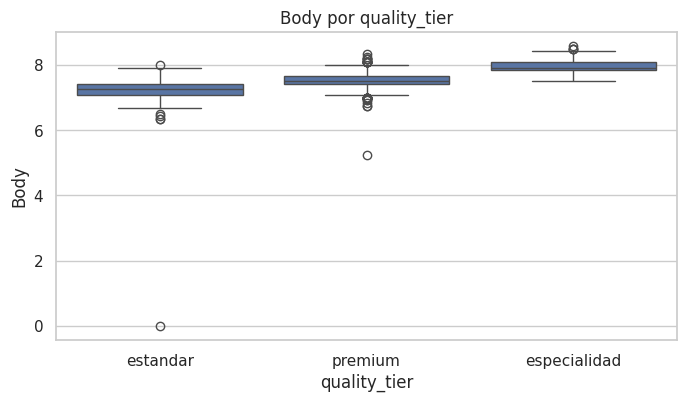

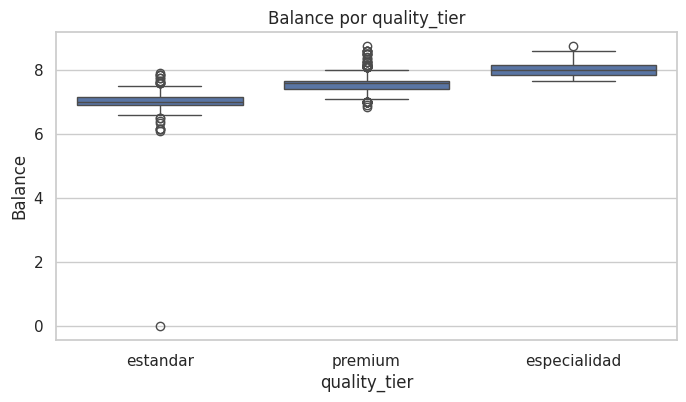

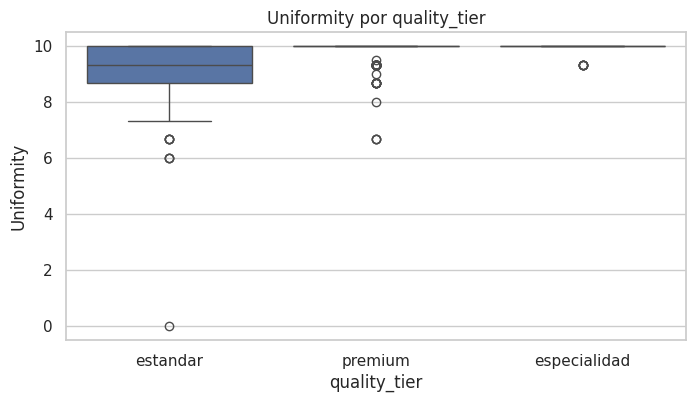

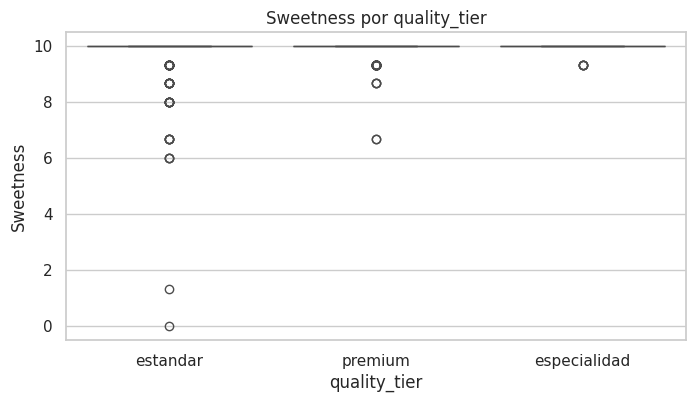

In [ ]:
#Atributos sensoriales principales
sens_cols = ["Aroma","Flavor","Aftertaste","Acidity","Body","Balance",
             "Uniformity","Clean Cup","Sweetness","Overall"]
sens_cols = [c for c in sens_cols if c in df.columns]

for c in sens_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='quality_tier', y=c, data=df, order=["estandar","premium","especialidad"])
    plt.title(f"{c} por quality_tier")
    plt.show()


Se analizaron los atributos Aroma, Flavor, Aftertaste, Acidity, Body, Balance, Uniformity, Clean Cup, Sweetness y Overall mediante diagramas de caja (boxplots) agrupados por quality_tier.

Los resultados muestran diferencias claras entre categorias:

* Los cafes de especialidad presentan valores más altos y consistentes en todos los atributos.

* Los cafes premium mantienen valores intermedios.

* Los cafes estandar tienen valores mas bajos y mayor dispersion.

Esto evidencia que los atributos sensoriales son determinantes en la clasificación de calidad.

### 3.6. Correlaciones

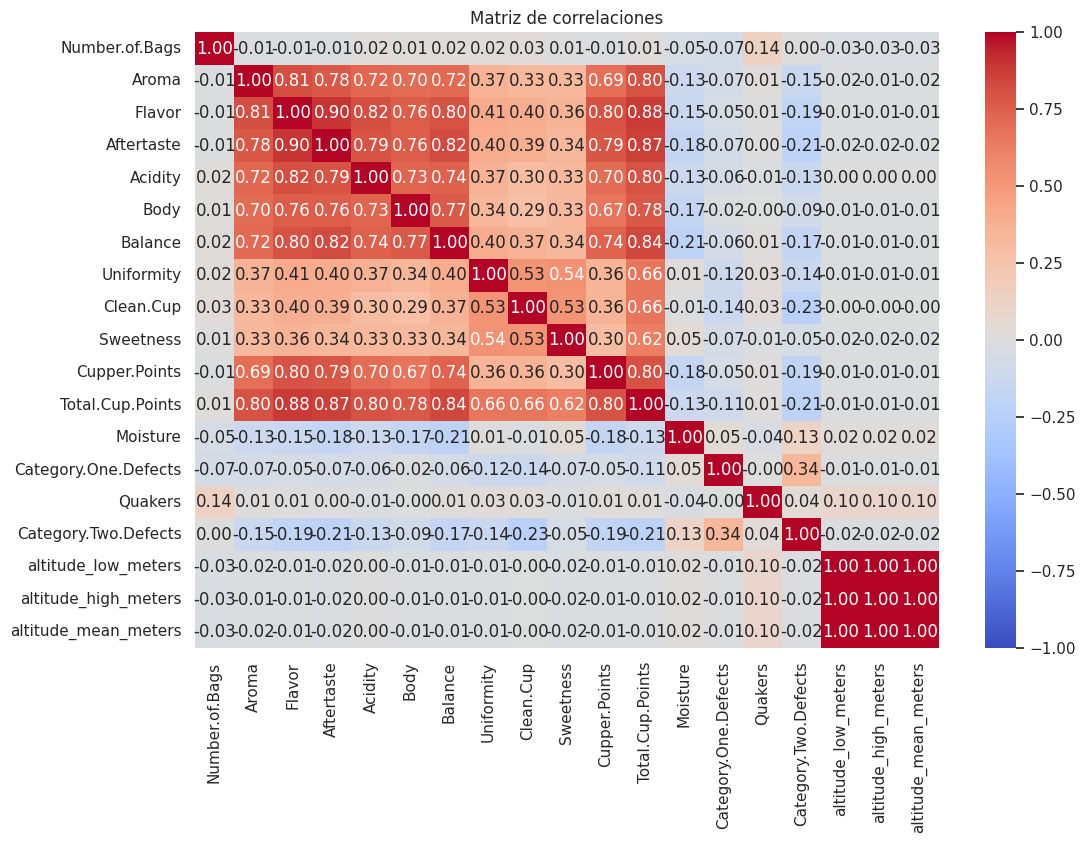

In [ ]:
#Matriz de correlacion y mapa de calor entre variables numericas.
num_for_corr = df.select_dtypes(include=[np.number]).loc[:, df.select_dtypes(include=[np.number]).std() > 0]
corr = num_for_corr.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlaciones")
plt.show()

In [ ]:
print("\nCaracteristicas mas correlacionadas con el total de puntos por copa")
print(corr[points_col].drop(labels=[points_col]).sort_values(key=lambda x: x.abs(), ascending=False).head(10))


Caracteristicas mas correlacionadas con el total de puntos por copa
Flavor           0.877988
Aftertaste       0.866111
Balance          0.836450
Cupper.Points    0.802050
Acidity          0.801064
Aroma            0.797364
Body             0.776533
Clean.Cup        0.661387
Uniformity       0.658138
Sweetness        0.617331
Name: Total.Cup.Points, dtype: float64


Los atributos sensoriales principales (Aroma, Flavor, Aftertaste, Acidity, Body, Balance) son los mas influyentes y altamente correlacionados.

Total.Cup.Points y Cupper.Points resumen bien la calidad del cafe.

Variables como defectos y altitud tienen poco peso directo en la matriz, pero aportan información complementaria.

### 3.7. Importancia de variables (RandomForest Regressor)

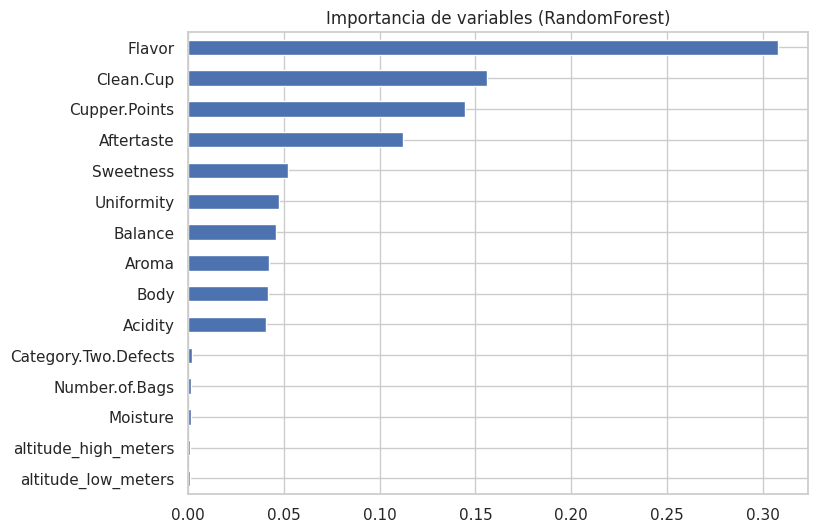

In [ ]:
X = num_for_corr.drop(columns=[points_col])
y = df[points_col]

X_imputed = X.fillna(X.median())

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_imputed, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Importancia de variables (RandomForest)")
plt.show()

El modelo de RandomForest confirma que la calidad del cafe esta determinada principalmente por atributos sensoriales, especialmente Flavor, Clean.Cup, Cupper.Points y Aftertaste. En contraste, características como Category.Two.Defects, Numbers.Of.Bags, Moisture, Altitud tienen muy poca relevancia en la clasificación de calidad.

## 4. Regresion

In [ ]:
#Seleccion de variables

target = "Total.Cup.Points"

features = [
    "Aroma","Flavor","Aftertaste","Acidity","Body","Balance",
    "Uniformity","Clean.Cup","Sweetness",
    "Moisture","Category.One.Defects","Category.Two.Defects","Quakers"
]

# Filtrar columnas disponibles en el dataset
features = [c for c in features if c in df.columns]

X = df[features]
y = df[target]

# Imputar los valores faltantes con la media
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=features)


#Dividir dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)
#Entrenar regresion lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicciones
y_pred = lr.predict(X_test)

#Evaluacion

# Metricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# R² ajustado
n = X_test.shape[0]
p = X_test.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)


In [ ]:
print("Metricas de desempeño del modelo de regresion:")
print(f"R²: {r2:.4f}")
print(f"R² ajustado: {r2_adj:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

# coeficientes de regresion lineal

coef_df = pd.DataFrame({
    "Variable": features,
    "Coeficiente": lr.coef_
}).sort_values(by="Coeficiente", ascending=False)

print("\nCoeficientes de la regresión lineal:")
print(coef_df)

Metricas de desempeño del modelo de regresion:
R²: 0.9918
R² ajustado: 0.9913
RMSE: 0.2269
MSE: 0.0515
MAE: 0.1348
MAPE: 0.1648%

Coeficientes de la regresión lineal:
                Variable  Coeficiente
1                 Flavor     1.366645
2             Aftertaste     1.285641
5                Balance     1.220580
4                   Body     1.062499
3                Acidity     1.045372
0                  Aroma     1.028728
6             Uniformity     1.019817
7              Clean.Cup     1.018533
8              Sweetness     0.973430
12               Quakers     0.004337
10  Category.One.Defects     0.001042
11  Category.Two.Defects    -0.004105
9               Moisture    -0.293516


R² = 0.9918 → El modelo explica el 99.18% de la variabilidad de la variable dependiente (Total.Cup.Points)

R² ajustado = 0.9913 → Similar al R², lo que indica que el modelo no esta sobreajustado y que las variables utilizadas realmente aportan información ("Aroma","Flavor","Aftertaste","Acidity","Body","Balance","Uniformity","Clean.Cup","Sweetness","Moisture","Category.One.Defects","Category.Two.Defects","Quakers").

RMSE = 0.2269 → Error cuadratico medio de raiiz bajo, significa que, en promedio, las predicciones se desvían poco respecto a los valores reales.

MSE = 0.0515 y MAE = 0.1349 → Los errores promedio son bajos, lo cual refuerza la buena capacidad predictiva.

MAPE = 0.1648% → El error porcentual promedio es inferior al 1%, prácticamente despreciable.


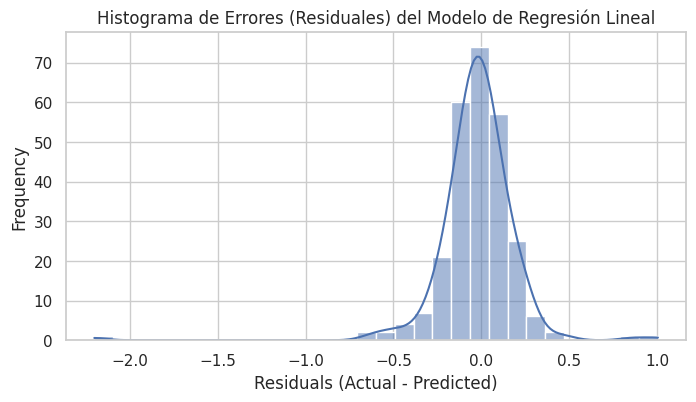

In [ ]:
# Calculate the residuals
residuals = y_test - y_pred

# Plot a histogram of the residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histograma de Errores (Residuales) del Modelo de Regresión Lineal")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

El histograma muestra que los residuales siguen una distribucin casi normal, centrada en 0 y con baja dispersión. Esto confirma que el modelo de regresion lineal está bien ajustado, predice con muy poca desviación respecto a los valores reales y cumple con los supuestos básicos de la regresión

In [ ]:
# Calcular media y desviacion estandar de los residuales
res_mean = np.mean(residuals)
res_std = np.std(residuals, ddof=1)  #

print(f"Media de los residuales: {res_mean:.4f}")
print(f"Desviación estándar de los residuales: {res_std:.4f}")

Media de los residuales: -0.0242
Desviación estándar de los residuales: 0.2261


## 6. Clasificacion

In [ ]:
# Preparar datos
features = X.columns.tolist()
X_class = X_imputed.copy()
y_class = df['quality_tier']

label_map = {"estandar":0, "premium":1, "especialidad":2}
y_enc = y_class.map(label_map)

X_train, X_test, y_train, y_test = train_test_split(X_class, y_enc, test_size=0.25, random_state=42, stratify=y_enc)

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["estandar","premium","especialidad"]))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

    estandar       0.93      0.91      0.92        47
     premium       0.98      0.98      0.98       257
especialidad       0.92      0.92      0.92        24

    accuracy                           0.97       328
   macro avg       0.94      0.94      0.94       328
weighted avg       0.97      0.97      0.97       328


Matriz de confusión:
[[ 43   4   0]
 [  3 252   2]
 [  0   2  22]]


El modelo logra una muy buena clasificacion de los cafés en sus tres categorías, alcanzando un 97% de exactitud y métricas de precisión, recall y F1-score muy altas en todas las clases. La matriz de confusión muestra pocos errores, principalmente entre las clases premium y las demás, lo cual es esperado por su similitud.
Este buen rendimiento es especialmente destacable porque el dataset está desbalanceado (257 casos de premium frente a solo 47 de estándar y 24 de especialidad). A pesar de esto, el modelo logra mantener resultados equilibrados entre clases, aunque la ligera mayor confusión ocurre entre premium y las demás categorías.

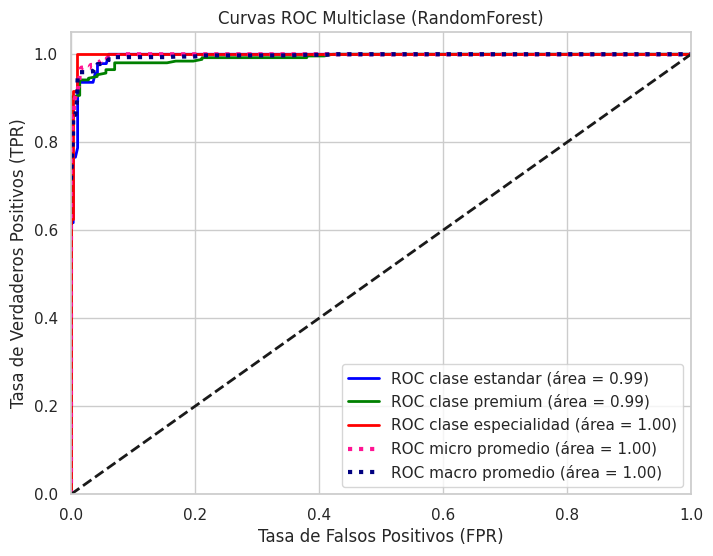

In [ ]:
# Binarizar etiquetas (para ROC multiclase)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Probabilidades de predicción
y_score = clf.predict_proba(X_test)

# Calcular ROC y AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro promedio
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC macro promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar
plt.figure(figsize=(8,6))
colors = ['blue','green','red']
class_names = ["estandar","premium","especialidad"]

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC clase {class_names[i]} (área = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'ROC micro promedio (área = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=3)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'ROC macro promedio (área = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC Multiclase (RandomForest)")
plt.legend(loc="lower right")
plt.show()


* El modelo Random Forest logró un desempeño excelente clasificando las tres categorías de café (estándar, premium y especialidad).

* Las curvas ROC muestran valores de AUC cercanos a 1.0 en todas las clases, lo que significa que el modelo distingue muy bien entre cada tipo de café.

* Tanto el promedio micro como el macro también alcanzan 1.0, indicando que el modelo funciona bien de forma global y también de manera equilibrada entre clases, incluso en las minoritarias.

* En términos simples: el modelo casi nunca se equivoca al predecir la clase de un café en los datos de prueba.

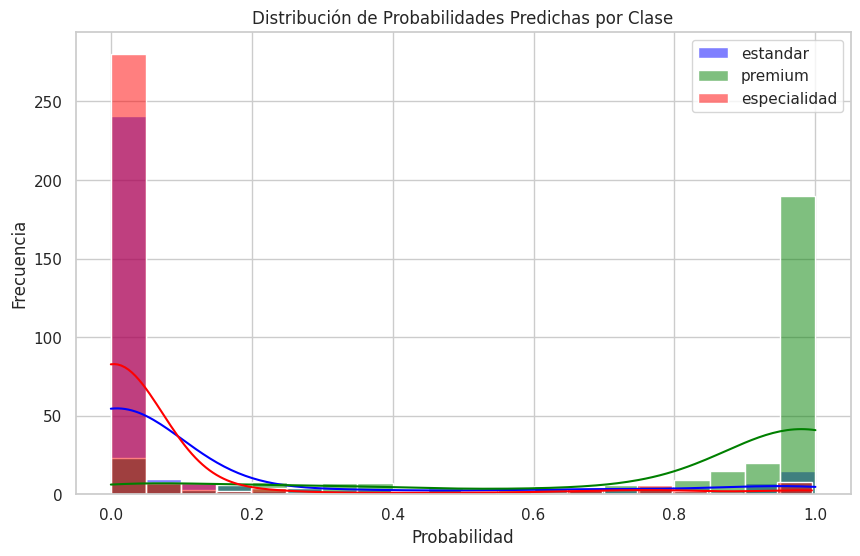

In [ ]:
import seaborn as sns

# Obtener las probabilidades predichas
y_proba = clf.predict_proba(X_test)

# Crear histograma de probabilidades por clase
plt.figure(figsize=(10,6))
colors = ['blue','green','red']
class_names = ["estandar","premium","especialidad"]

for i, color in zip(range(y_proba.shape[1]), colors):
    sns.histplot(y_proba[:, i], bins=20, kde=True, color=color, label=f"{class_names[i]}")

plt.title("Distribución de Probabilidades Predichas por Clase")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()




Concentración en extremos (0 y 1):

* La mayoría de las predicciones están muy cerca de 0 o de 1.
  Esto significa que el modelo casi siempre está muy seguro al decidir si una muestra pertenece o no a una clase.

* Muy pocas probabilidades intermedias (0.3 – 0.7):
  Indica que el modelo rara vez duda; toma decisiones bastante firmes.
  Es coherente con los AUC ≈ 1 que viste en la curva ROC.

* Clases minoritarias (premium y especialidad):
  También muestran barras fuertes en 0 y en 1, lo que implica que, aunque tienen menos datos, el modelo logra clasificarlas con alta seguridad.

Preubas para mejorar la clasificacion

Undersampling

Es una técnica de balanceo de clases que consiste en reducir el número de instancias de la(s) clase(s) mayoritaria(s).

In [ ]:
#Undersampling
# 1. Preparar X e y
features1 = X.columns.tolist()
X1_class = X_imputed.copy()
y1_class = df['quality_tier']

# Mapeo de etiquetas
label_map1 = {"estandar":0, "premium":1, "especialidad":2}
y1_enc = y1_class.map(label_map1)

print("Distribución original:", dict(zip(*np.unique(y1_enc, return_counts=True))))


# 2. Undersampling

rus1 = RandomUnderSampler(random_state=42)
X1_res, y1_res = rus1.fit_resample(X1_class, y1_enc)

print("Distribucion balanceada:", dict(zip(*np.unique(y1_res, return_counts=True))))


# 3. Train/Test Split

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1_res, y1_res, test_size=0.25, random_state=42, stratify=y1_res
)


# 4. Entrenamiento del modelo

clf1 = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
clf1.fit(X1_train, y1_train)


# 5. Predicciones y métricas

y1_pred = clf1.predict(X1_test)

print("\nClassification report:")
print(classification_report(y1_test, y1_pred, target_names=["estandar","premium","especialidad"]))

print("\nMatriz de confusión:")
print(confusion_matrix(y1_test, y1_pred))


Distribución original: {np.int64(0): np.int64(189), np.int64(1): np.int64(1026), np.int64(2): np.int64(96)}
Distribucion balanceada: {np.int64(0): np.int64(96), np.int64(1): np.int64(96), np.int64(2): np.int64(96)}

Classification report:
              precision    recall  f1-score   support

    estandar       1.00      1.00      1.00        24
     premium       0.92      0.92      0.92        24
especialidad       0.92      0.92      0.92        24

    accuracy                           0.94        72
   macro avg       0.94      0.94      0.94        72
weighted avg       0.94      0.94      0.94        72


Matriz de confusión:
[[24  0  0]
 [ 0 22  2]
 [ 0  2 22]]


 Oversampling

 tecnica de balanceo de clases en datasets desbalanceados que consiste en aumentar el número de instancias de las clases minoritarias para que queden equilibradas respecto a la(s) clase(s) mayoritaria(s).

In [ ]:
#Oversampling
# 1. Preparar X e y

features2 = X.columns.tolist()
X2_class = X_imputed.copy()
y2_class = df['quality_tier']

# Mapeo de etiquetas
label_map2 = {"estandar":0, "premium":1, "especialidad":2}
y2_enc = y2_class.map(label_map2)

print("Distribución original:", dict(zip(*np.unique(y2_enc, return_counts=True))))


# 2. Oversampling
ros2 = RandomOverSampler(random_state=42)
X2_res, y2_res = ros2.fit_resample(X2_class, y2_enc)

print("Distribucion balanceada:", dict(zip(*np.unique(y2_res, return_counts=True))))


# 3. Train/Test Split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_res, y2_res, test_size=0.25, random_state=42, stratify=y2_res
)


# 4. Entrenamiento del modelo
clf2 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf2.fit(X2_train, y2_train)


# 5. Predicciones y metricas
y2_pred = clf2.predict(X2_test)

print("\nClassification report:")
print(classification_report(y2_test, y2_pred, target_names=["estandar","premium","especialidad"]))

print("\nMatriz de confusión:")
print(confusion_matrix(y2_test, y2_pred))


Distribución original: {np.int64(0): np.int64(189), np.int64(1): np.int64(1026), np.int64(2): np.int64(96)}
Distribucion balanceada: {np.int64(0): np.int64(1026), np.int64(1): np.int64(1026), np.int64(2): np.int64(1026)}

Classification report:
              precision    recall  f1-score   support

    estandar       0.98      1.00      0.99       256
     premium       1.00      0.96      0.98       257
especialidad       0.99      1.00      0.99       257

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770


Matriz de confusión:
[[256   0   0]
 [  6 248   3]
 [  0   0 257]]


Undersampling +  Oversampling

In [ ]:
#Undersampling +  Oversampling
# 1. Preparar X e y

features3 = X.columns.tolist()
X_class3 = X_imputed.copy()
y_class3 = df['quality_tier']

# Mapeo de etiquetas
label_map3 = {"estandar":0, "premium":1, "especialidad":2}
y_enc3 = y_class3.map(label_map3)

print("Distribución original:", dict(zip(*np.unique(y_enc3, return_counts=True))))

# 2. Balanceo mixto
target_samples3 = 250

# 1) Reducir la clase mayoritaria (1 → 250)
under3 = RandomUnderSampler(sampling_strategy={1: target_samples3}, random_state=42)

# 2) Aumentar las minoritarias (0 y 2 → 250)
over3 = RandomOverSampler(sampling_strategy={0: target_samples3, 2: target_samples3}, random_state=42)

# 3) Encadenar en pipeline
pipeline3 = Pipeline(steps=[('u', under3), ('o', over3)])

X_res3, y_res3 = pipeline3.fit_resample(X_class3, y_enc3)

print("Distribución balanceada:", dict(zip(*np.unique(y_res3, return_counts=True))))

# 3. Train/Test Split
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X_res3, y_res3, test_size=0.25, random_state=42, stratify=y_res3
)

# 4. Entrenamiento del modelo
clf3 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf3.fit(X_train3, y_train3)

# 5. Predicciones y métricas
y_pred3 = clf3.predict(X_test3)

print("\nClassification report:")
print(classification_report(y_test3, y_pred3, target_names=["estandar","premium","especialidad"]))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test3, y_pred3))


Distribución original: {np.int64(0): np.int64(189), np.int64(1): np.int64(1026), np.int64(2): np.int64(96)}
Distribución balanceada: {np.int64(0): np.int64(250), np.int64(1): np.int64(250), np.int64(2): np.int64(250)}

Classification report:
              precision    recall  f1-score   support

    estandar       0.97      1.00      0.98        62
     premium       1.00      0.92      0.96        63
especialidad       0.95      1.00      0.98        63

    accuracy                           0.97       188
   macro avg       0.97      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188


Matriz de confusión:
[[62  0  0]
 [ 2 58  3]
 [ 0  0 63]]


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Guardamos resultados en una lista
results = []

# --- Modelo Normal ---
results.append({
    "Modelo": "Normal",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1-macro": classification_report(y_test, y_pred, output_dict=True)["macro avg"]["f1-score"],
    "Recall-macro": classification_report(y_test, y_pred, output_dict=True)["macro avg"]["recall"],
    "Precision-macro": classification_report(y_test, y_pred, output_dict=True)["macro avg"]["precision"]
})

# --- Undersampling ---
results.append({
    "Modelo": "Undersampling",
    "Accuracy": accuracy_score(y1_test, y1_pred),
    "F1-macro": classification_report(y1_test, y1_pred, output_dict=True)["macro avg"]["f1-score"],
    "Recall-macro": classification_report(y1_test, y1_pred, output_dict=True)["macro avg"]["recall"],
    "Precision-macro": classification_report(y1_test, y1_pred, output_dict=True)["macro avg"]["precision"]
})

# --- Oversampling ---
results.append({
    "Modelo": "Oversampling",
    "Accuracy": accuracy_score(y2_test, y2_pred),
    "F1-macro": classification_report(y2_test, y2_pred, output_dict=True)["macro avg"]["f1-score"],
    "Recall-macro": classification_report(y2_test, y2_pred, output_dict=True)["macro avg"]["recall"],
    "Precision-macro": classification_report(y2_test, y2_pred, output_dict=True)["macro avg"]["precision"]
})

# --- Undersampling + Oversampling ---
results.append({
    "Modelo": "Under+Over",
    "Accuracy": accuracy_score(y_test3, y_pred3),
    "F1-macro": classification_report(y_test3, y_pred3, output_dict=True)["macro avg"]["f1-score"],
    "Recall-macro": classification_report(y_test3, y_pred3, output_dict=True)["macro avg"]["recall"],
    "Precision-macro": classification_report(y_test3, y_pred3, output_dict=True)["macro avg"]["precision"]
})

# Convertir a DataFrame
df_results = pd.DataFrame(results)
print(df_results)


          Modelo  Accuracy  F1-macro  Recall-macro  Precision-macro
0         Normal  0.966463  0.940013      0.937368         0.942731
1  Undersampling  0.944444  0.944444      0.944444         0.944444
2   Oversampling  0.988312  0.988264      0.988327         0.988520
3     Under+Over  0.973404  0.973183      0.973545         0.974432


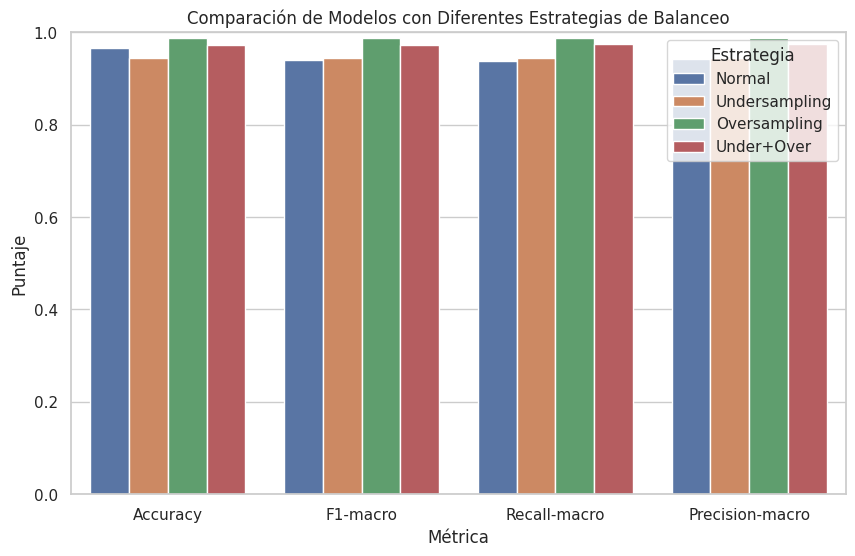

In [ ]:
# Pasamos a formato largo para graficar fácilmente
df_melt = df_results.melt(id_vars="Modelo",
                          value_vars=["Accuracy", "F1-macro", "Recall-macro", "Precision-macro"],
                          var_name="Métrica", value_name="Valor")

plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x="Métrica", y="Valor", hue="Modelo")

plt.title("Comparación de Modelos con Diferentes Estrategias de Balanceo")
plt.ylabel("Puntaje")
plt.ylim(0, 1)  # porque métricas están entre 0 y 1
plt.legend(title="Estrategia")
plt.show()


El mejor modelo es el de Oversampling, porque alcanza el valor mas alto en Accuracy, F1-macro, Recall y Precision, lo que significa que logra un equilibrio adecuado en la clasificación de las tres categorias.

El Under+Over tambien es una buena opción, pero su rendimiento es ligeramente menor.
El Normal funciona bien, pero puede estar afectado por el desbalance.
El Undersampling es el más debil porque pierde información.